# Data validation through classification of signal dynamics

## Using phase portraits to identify obstructed sensors

This tutorial runs through the method of data validation described in <i>"ML-assisted, process-based validation of environmental sensor data"</i> (Schmidt and Kerkez, 2023). Given a set of timeseries labeled clean/obstructed, a binary classifier is trained to detect whether a sesnor is operating as expected or not. This method is intended for use on raw sensor data from environmental sensors deployed in the field. It is particularly useful for detecting sensor obstructions - incidents where the sensor is no longer measuring the target variable (e.g. a water quality sensor becomes fouled, a tree branch blocks the sensor's line of sight, a hardware malfunction occurs, etc.)

We'll start by importing the relevant libraries. 

In [1]:
# data processing 
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_predict, GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# plotting
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# other files in this repo
from utils import import_wl_data, import_ph_data, unit_scale, remove_outliers, take_derivative, cut_ends
from models.data_validation import ReportErrors

# make the notebook look pretty
import warnings
warnings.filterwarnings('ignore')

Next up is loading in the metadata files, which we will use to access our training datasets. The data used in this tutorial come from a large (130+) sensor network measuring water level and water quality across the state of Michigan (USA). All of the data were collected via low-cost open-source water level, pH, and electroconductivity sensors developed by the [Open-storm](http://open-storm.org/) collaboration. Check out that link if you're interested in building and deploying these sensors yourself, or check out the [sensor network map](http://maps.open-storm.org/) if you want to access the most recent data. For this tutorial, all the data you'll need (and more) can be found in the __data/__ folder of this repository. 

We load in metadata csv's for the water level and pH sensor datasets. Both csv's have _Site ID_ and _Node ID_ columns, unique identifiers tracking where the sensors were deployed and which devices were used to collect each sample. Each sample in the water level dataset is a time series of 120 days worth of measurements, while each pH sample contains 30 days worth of measurements. Some of the samples have the same Site and Node IDs - these can be distinguished by the _start_ and _end_ timestamps. The _Offset (mm)_ column in the water level dataset is used to convert the raw water level sensor data (measured as the distance from the transducer to the water) into water depth. The _Clean_ column provides the manual labeling for if the timeser contains an obstruction data fault or not. 

In [2]:
depth120d = pd.read_csv("data/metadata - 120d.csv")
pH_meta = pd.read_csv("data/wq_metadata - pH.csv")

In [3]:
depth120d.head()

,Node ID,Site ID,start,end,Offset (mm),Clean
0,001A,MDOT11328,2022-07-31 18:37:00+00:00,2022-11-28 18:37:00+00:00,9448.80,0
1,003A,ARB017,2022-04-02 18:32:00+00:00,2022-07-31 18:32:00+00:00,1517.65,1
2,003A,ARB017,2022-07-31 18:32:00+00:00,2022-11-28 18:32:00+00:00,1517.65,1
3,004A,MDOT335,2022-07-31 18:31:00+00:00,2022-11-28 18:31:00+00:00,2476.50,1
4,004A,PTK016,2021-06-25 17:08:00+00:00,2021-10-23 17:08:00+00:00,1670.00,0


In [4]:
pH_meta.head()

,node_id,site_id,start,end,clean,issue
0,001E,A1,2021-07-21 18:03:56+00:00,2021-07-30 16:41:44+00:00,1,NaN
1,001E,A1,2021-07-30 16:41:44+00:00,2021-08-29 16:41:44+00:00,1,NaN
2,001E,A1,2021-08-29 16:41:44+00:00,2021-09-28 16:41:44+00:00,1,NaN
3,001E,A1,2021-09-28 16:41:44+00:00,2021-10-28 16:41:44+00:00,1,NaN
4,002E,A1,2021-08-02 19:36:51+00:00,2021-08-28 14:54:24+00:00,1,NaN


First let's take a look at some of the data - both clean and obstructed examples.

In the cell below we import data (import_wl_data, import_ph_data) and then plot several time series. 

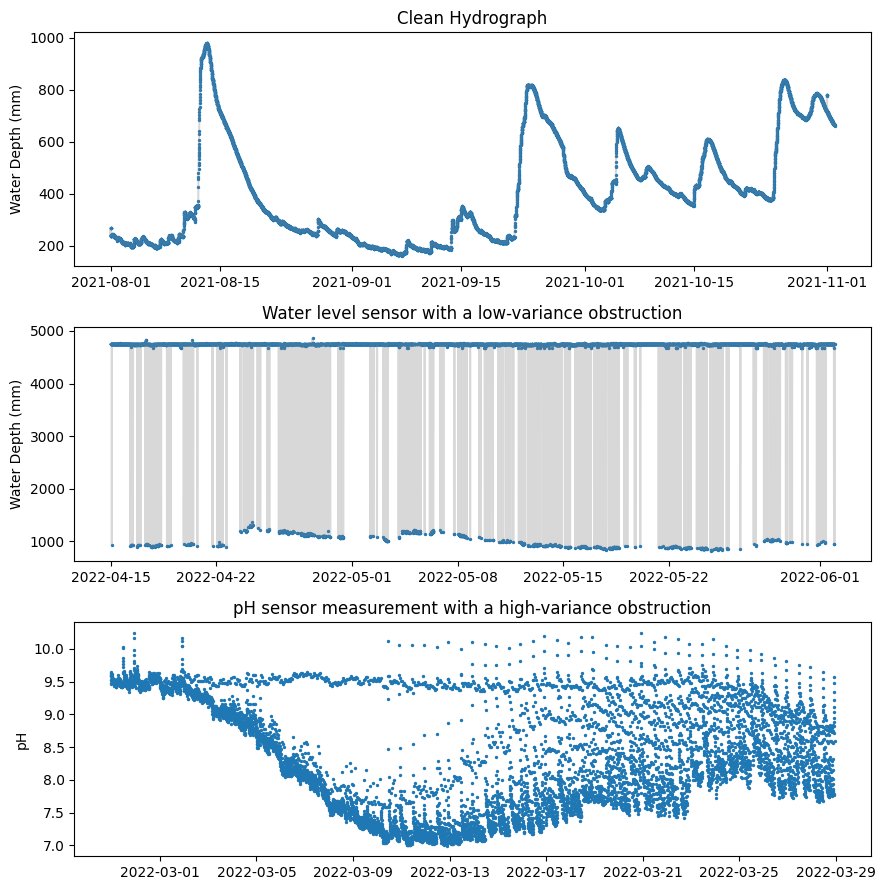

In [5]:
# import data
clean_site = import_wl_data(index = 22)
clean_site = clean_site['2021-08-01':'2021-11-01']
lo_var = import_wl_data(index=101)
lo_var = lo_var['2022-04-15':'2022-06-01']
col = pH_meta.iloc[80]
hi_var = import_ph_data(col['node_id'], col['start'], col['end'])

# plot
fig, ax = plt.subplots(nrows=3,figsize=(9,9))
ax[0].scatter(clean_site.index, clean_site['Value'], s=2)
ax[0].plot(clean_site.index, clean_site['Value'], c='grey', alpha=0.3)
ax[1].scatter(lo_var.index, lo_var['Value'], s=2)
ax[1].plot(lo_var.index, lo_var['Value'], c='grey', alpha=0.3)
ax[2].scatter(hi_var.index, hi_var['Value'], s=2)
ax[0].set_title("Clean Hydrograph")
ax[1].set_title("Water level sensor with a low-variance obstruction")
ax[2].set_title("pH sensor measurement with a high-variance obstruction")
ax[0].set_ylabel("Water Depth (mm)")
ax[1].set_ylabel("Water Depth (mm)")
ax[2].set_ylabel("pH")
plt.tight_layout()

One of the biggest challenges with detecting obstructed sensors is the sheer variety of ways the obstruction can present itself in the data. Sometimes the obstruction looks like data jumping randomly between two levels, sometimes the obstruction is a patch of fuzzy noise that may or may not be centered around the mean of the actual signal, and sometimes its a combination of the two. As a result, its very difficult to design a series of rule-based statistical tests that can comprehensively detect all of the possible obstruction patterns. Similarly, when a sensor network is deployed over a large area, a large number of valid behaviors can be seen in the data, which makes it hard to train a statistical model to always recognize valid signals. 

Obstruction data all have one thing in common however -- they are a deviation from the expected dynamics of the sensor measurement. By visualizing those dynamics, we can train a classifier to discriminate between obstructed and valid time series data for us -- better than we can by using heuristic rules or an auto-tunned purely statistical model. Below, we show a plot of several timeseries and their dynamics as visualized in a [phase portrait](https://en.wikipedia.org/wiki/Phase_portrait), a plot of value vs. first derivative. 

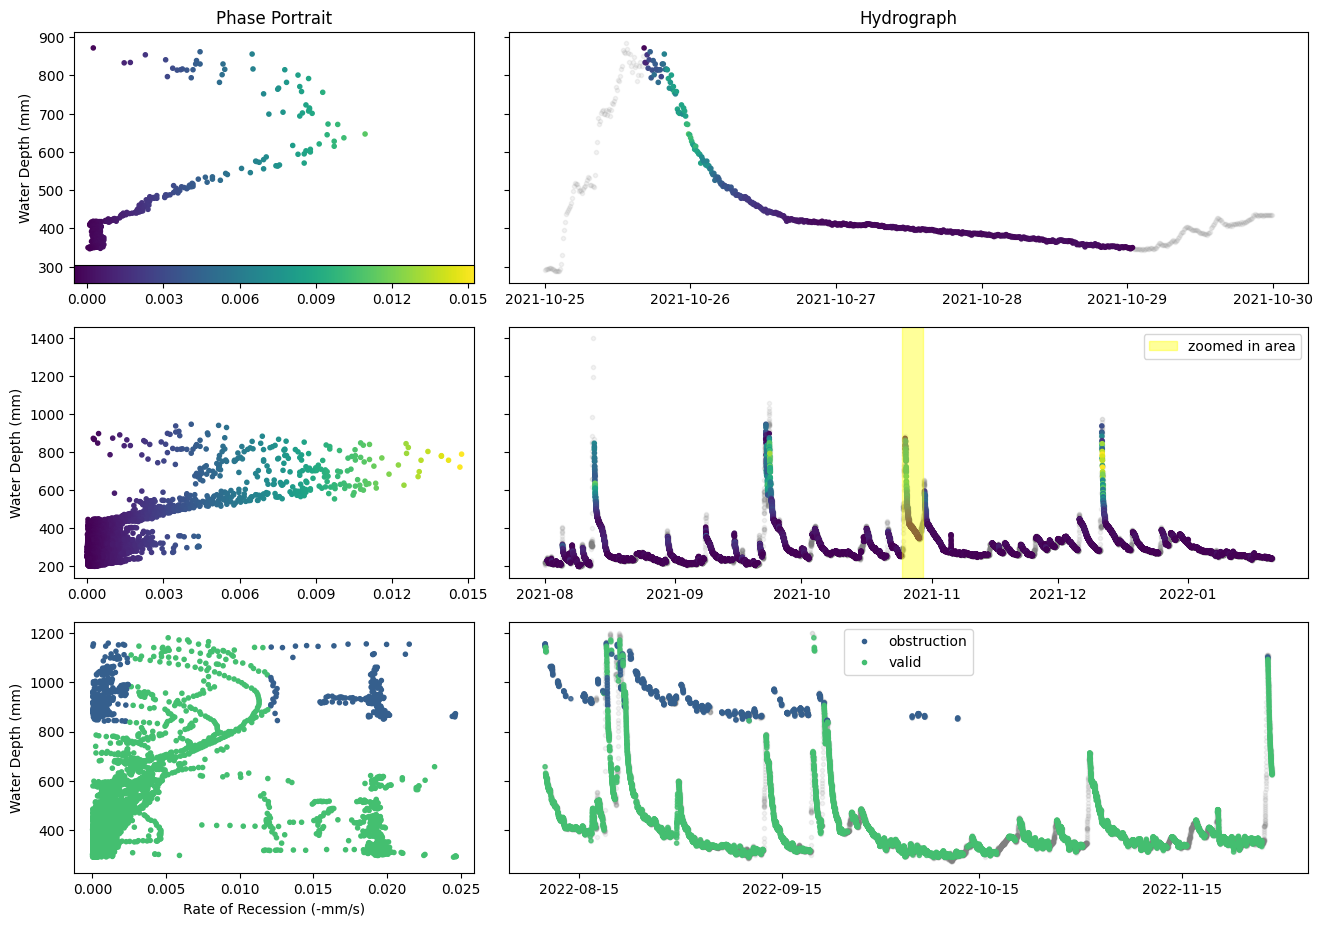

In [6]:
### Define the data for the clean hydrograph ###
df = import_wl_data(index = 82)
df = df[df['Value'] < 1400] # cuts out a few outliers for clarity - these don't constitute a sensor obstruction
df = df['2021-08':'2022-01-20']
df, df_down, df_up = take_derivative(df)
sub_df = df["2021-10-25 00:00:00+00:00":"2021-10-30 00:00:00+00:00"] # we also zoom in on a subset of this data
sub_df, sub_df_down, sub_df_up = take_derivative(sub_df)

### Define the data for the obstructed hydrograph ###
obst = import_wl_data(index = 68)
obst_plot = obst[obst['Value'] >0]
obst_plot = obst_plot[obst_plot['Value'] < 1200]
obst_c = cut_ends(obst) # we trim the 1st and 99th percentile of the data off for clarity
obst_c, obst_down, obst_up = take_derivative(obst_c)

### Manually highlight clusters of obstructed data ###
outliers_1 = np.where(obst_down['Value'] > 800, -1, 0)
outliers_2 = np.where(obst_down['mean diff'] < -0.012, -1, 0)
outliers_3 = np.where(obst_down['mean diff'] > -0.0025, -1, 0)
outliers = np.where(outliers_1 + outliers_2 + outliers_3== -2, -1, 0)

### Define a trimmed version of viridis to keep colors consistent ###
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('viridis')
short_viridis = truncate_colormap(cmap, 0.3, 0.7)
short_viridis

### Create the plot ###
fig, ax = plt.subplots(ncols=2, nrows=3, figsize = (14, 9), sharey='row', gridspec_kw={'width_ratios': [1, 2]})
plt.tight_layout()
# clean up the color scheme 
norm = mpl.colors.Normalize(vmin=min(-1*df_down['mean diff']), vmax=max(-1*df_down['mean diff']))
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
color_range = cm.get_cmap('viridis', len(-1*df_down['mean diff']))
legend_elements = [Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=short_viridis(0),c=short_viridis(0), label='obstruction'),
                   Line2D([0], [0], marker='.', linewidth=0, markerfacecolor=short_viridis(0.99),c=short_viridis(0.99), label='valid',)]

ax[0,0].set_title("Phase Portrait")
ax[0,0].set_xticks([0.000, 0.003, 0.006, 0.009, 0.012, 0.015])
ax[0,0].set_xlim([-0.0005,max(-1*df_down['mean diff'])+0.0005])
ax[0,0].scatter(-1*sub_df_down['mean diff'], sub_df_down['Value'], marker='.',c=-1*sub_df_down['mean diff'], cmap=color_range, norm=norm)
ax[0,0].set_ylabel('Water Depth (mm)')
ax[0,1].scatter(sub_df.index, sub_df['Value'], marker = '.', color='grey', alpha=0.1)
ax[0,1].scatter(sub_df_down.index, sub_df_down['Value'], c=-1*sub_df_down['mean diff'], cmap=color_range, marker = '.', norm=norm)
ax[0,1].set_title("Hydrograph")
ax[1,0].scatter(-1*df_down['mean diff'], df_down['Value'], marker='.', c=-1*df_down['mean diff'], cmap=color_range, norm=norm)
ax[1,0].set_ylabel('Water Depth (mm)')
ax[1,0].set_xticks([0.000, 0.003, 0.006, 0.009, 0.012, 0.015])
ax[1,0].set_xlim([-0.0005,max(-1*df_down['mean diff'])+0.0005])
ax[1,1].scatter(df.index, df['Value'], marker = '.', color='grey', alpha=0.1)
ax[1,1].scatter(df_down.index, df_down['Value'], c=-1*df_down['mean diff'], cmap=color_range, marker = '.', norm=norm)
ax[1,1].axvspan("2021-10-25 00:00:00+00:00","2021-10-30 00:00:00+00:00", alpha=0.4, color='yellow', label="zoomed in area")
ax[1,1].legend()
ax[2,0].scatter(-1*obst_down['mean diff'], obst_down['Value'], marker='.', c=outliers, cmap=short_viridis)
ax[2,0].set_ylabel('Water Depth (mm)')
ax[2,0].set_xlabel('Rate of Recession (-mm/s)')
ax[2,1].scatter(obst_plot.index, obst_plot['Value'], marker='.', c='grey', alpha=0.1)
ax[2,1].scatter(obst_down.index, obst_down['Value'], marker='.', c=outliers, cmap=short_viridis, alpha=0.8)
ax[2,1].set_xticks(['2022-08-15', '2022-09-15', '2022-10-15', '2022-11-15'])
ax[2,1].legend(handles=legend_elements)

# add in colorbar
ax1_divider = make_axes_locatable(ax[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="-7%")
cbar = plt.colorbar(sm, orientation="horizontal", cax=cax1)
cbar.set_ticks([])

plt.subplots_adjust(left=0.1)

The phase portraits shown above (left column) are a direct visualization of the first order dynamics of the signal. By plotting the value (y-axis) vs. the derivative (x-axis), we are directly visualizing trends in the first-order differential dynamics of the environmental process being measured. Environmental processes $p(t)$ change according to their current state and can be modelled by the following differential equation:
$$\frac{dp}{dt}=f(p)$$
where $f(p)$ is a potentially non-linear function of $p(t)$. Curves in the phase portrait trace $f(p)$, making it a direct visualization of how the system dynamically evolves based on its current state. 

In the above plot, we have illustrated phase portraits for two timeseries signals measured at two different sites. Row 1 and row 2 show the same timeseries, with row 1 zoomed in on a single storm. These rows both illustrate the expected phase portrait for a clean water level timeseries. Row 3 shows an obstructed water level sensor timeseries and the associated phase portrait. 

As we can see in the phase portraits for the clean timeseries (rows 1 and 2), the dynamics of the signal follows a repeatable trend -- that sideways parabola. Different storms introduce different volumes of water to the catchment, but when the rain is over, the water level decreases in this same pattern. At first water level drops slowly, then it speeds up reaching an inflection point (peak of the parabola) before slowing down again until it reaches the baseline level (lower left corner of the phase portrait). 

Row 3 shows that when the sensor is obstructed, however, the pattern in the phase portrait is broken, resulting in visible clusters of obstructed data. The obstruction data is colored in dark blue for reference. Visually, the phase portraits from the clean sensor data and the obstructed sensor data are clearly distinguishable. Even though these measurements were taken at different catchments, we can see that without the obstruction data, the phase portrait of the 3rd row would resemble the phase portraits in the first two rows. The pattern we're seing in the phase portrait is related to the physics underlying how water level changes in rivers and lakes. For this reason, we can look at all of the data measured across an entire sensor network to learn how to distinguish valid and non-physical sensor measurements.

We ultimately want to use a binary classifier to distinguish between valid and obstructed signals, but in order to do that, we need our data to be directly comparable to each other. We acomplish this by binning and normalizing the phase portrait. Using a 2D histogram, which is then passed through a min-max unit scaler and a standard scaler, we create an encoding for the timeseries data that captures information about the distribution of the phase portrait. This encoding is what we use as input to the binary classification model. 

In [7]:
def show_data_with_encoding(i=0, depth_meta=depth120d):
    node_id = depth_meta.iloc[i]['Node ID']
    site_id = depth_meta.iloc[i]['Site ID']
    offset = depth_meta.iloc[i]['Offset (mm)']

    df = import_wl_data(node_id=node_id, site_id=site_id)
    df = df[depth_meta.iloc[i]['start']:depth_meta.iloc[i]['end']]
    df, flag = flag_depth_errors(df, offset)
    df, depth_down, depth_up = add_derv(df)
    
    X = np.array(depth_down[['Value', 'mean diff']])
    h, x_e, y_e = np.histogram2d(X[:,0], -1*X[:,1], [9, 6])
    h = np.reshape(h, (-1,1))
    mm = make_pipeline(StandardScaler(), MinMaxScaler())
    h = mm.fit_transform(h)
    h = np.reshape(h, (9, 6))
    h1d, x_e1d = np.histogram(X[:,0], 10)
    h1d = np.reshape(h1d, (-1,1))
    mm = make_pipeline(StandardScaler(), MinMaxScaler())
    h1d = mm.fit_transform(h1d)
    
    fig, ax = plt.subplots(figsize=(16,3), ncols=4, gridspec_kw={'width_ratios': [5, 5, 1, 10]})
    ax[0].scatter(-1*depth_down['mean diff'], depth_down['Value'], marker='.')
    ax[3].scatter(df.index, df['Value'], marker='.')
    clean = depth_meta.iloc[i]['Clean']
    ax[3].set_title(f"{node_id} {site_id} - Label: {clean}")
    norm1 = mpl.colors.Normalize(vmin=min(-1*depth_down['mean diff']), vmax=max(-1*depth_down['mean diff']))
    ax[1].imshow(h, cmap='viridis', aspect='auto',norm=norm1, origin='lower')
    ax[2].imshow(h1d, cmap='viridis', aspect='auto',norm=norm1, origin='lower')
    ax[2].set_xticks([])
    return plt.show()

### calculates the derivative and separates out receeding and ascending sections of data ###
def add_derv(df, tol = 0.00001):
    df = df.copy()
    df['smoothed'] = df['Value'].rolling(window=6*8, min_periods=1, center=True).mean()
    df['mean diff'] = df['smoothed'].diff(1).fillna(0) / df.index.to_series().diff(periods=1).dt.seconds #careful for non-USGS data
    df = df.drop(df[df['mean diff'] < -1e308]['mean diff'].index)
    df_down = df[df['mean diff'] < -1*tol]
    df_up = df[df['mean diff'] >= tol]
    
    return df, df_down, df_up

### runs a couple of site-agnostic rules based tests on the data ###
def flag_depth_errors(df, offset):
    
    flag = False
    df, neg_flag, sat_flag = ReportErrors.detect_out_of_range(df, offset)
    df, und_flag = ReportErrors.detect_underliers(df)
    
    if neg_flag:
        flag = True
    if sat_flag:
        flag = True
    if und_flag:
        flag = True
    
    return df, flag

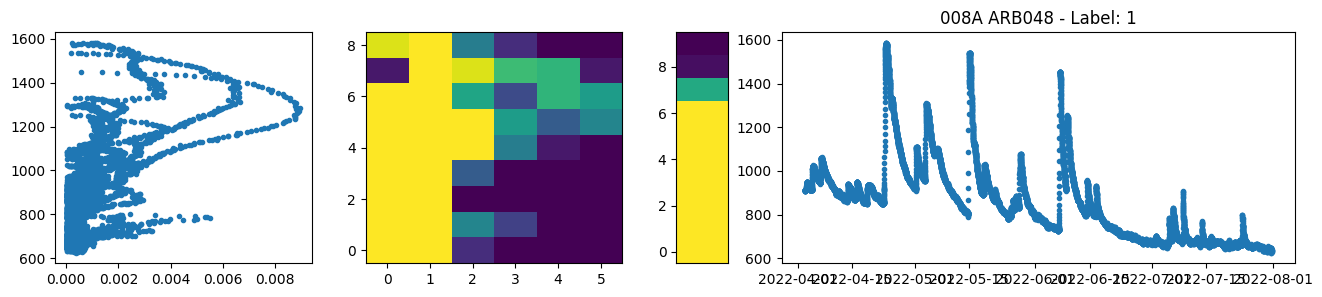

In [8]:
show_data_with_encoding(13)

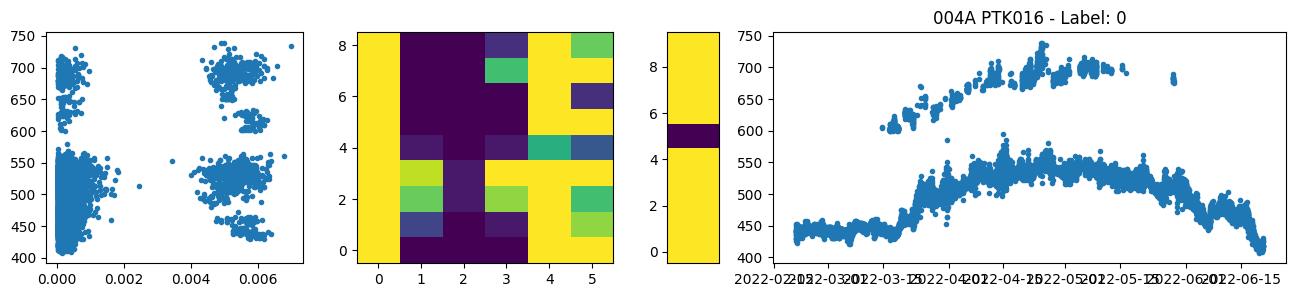

In [9]:
show_data_with_encoding(6)

The above figure has four columns from left to right,: the phase portrait, a 2D normalized histogram of the phase portrait, a 1D histogram taken just over the value dimension, and the original time series. 

The first figure is of a clean time series, while the second figure is of an obstructed time series. We can see a distinct differece in the phase portraits for the samples. The distribution of data is very different between both phase portraits, and this is visible in the binned phase portrait (second column). The difference is also visible in the 1D histogram - with the noisy signal showing a gap in the middle of the histogram that the clean signal does not have. For this reason, we try out binary classification on both the 2D binned phase portrait and the 1D binned value distribution. 

The general sequence of steps to creating a binary classification model are as follows:

        1. Collect sensor data from a network of the same kind of sensor measuring the same process
        2. Break each timeseries into evenly sized chunks - these are our samples. 
            - How long is a chunk? This is a hyperparameter, it may require some experimentation. 
        3. Manually label each sample based on if there is any obstruction data in the timeseries chunk. 
            - A label of 0 is given to obstructed samples whose sensors require field maintenance. 
            - A label of 1 is given to clean samples whose sensors are fine.
        4. Encode each sample by taking a histogram and normalizing it (described above). 
        5. We are ready to train the binary classifier. 
        
Below we show the code for encoding data and training the binary classifier. A number of binary classifiers can be used, we show the implementation for a couple of them. 

In [10]:
### functions that perform a grid search to optimize parameters for classification models ###
def mlp_classification(data, y, scoring = 'accuracy'):
    params = [{'alpha': [0.001, 0.01, 0.1, 1], 
               'random_state': [0,1,2,3,4,5,6,7,8], 
               'hidden_layer_sizes': [10, 50, 75, 100], 
              }]
    mlp_pipe = MLPClassifier()
    gs_mlp = GridSearchCV(mlp_pipe, param_grid=params, scoring=scoring, cv=5)
    gs_mlp.fit(data, y)
    return gs_mlp.best_params_

def svm_classification(data, y, scoring = 'accuracy'):
    params = [{'kernel':['linear', 'rbf', 'poly'], 'C':[0.1, 1, 10, 100]}]
    clf_pipe = SVC()
    gs_clf = GridSearchCV(clf_pipe, param_grid=params, scoring=scoring, cv=5)
    gs_clf.fit(data, y)
    return gs_clf.best_params_

def nb_classification(data, y, scoring = 'accuracy'):
    
    params = [{'var_smoothing': [1e-10, 1e-9, 1e-8]}]
    clf_pipe = GaussianNB()
    gs_clf = GridSearchCV(clf_pipe, param_grid=params, scoring=scoring, cv=5)
    gs_clf.fit(data, y)
    return gs_clf.best_params_
    
def ada_classification(data, y, scoring = 'accuracy'):
    
    params = [{'n_estimators':[10,25,50,100,250]}]
    ada_pipe = AdaBoostClassifier() 
    gs_ada = GridSearchCV(ada_pipe, param_grid=params, scoring=scoring, cv=5)
    gs_ada.fit(data, y)
    return gs_ada.best_params_

def gp_classification(data, y, scoring = 'accuracy'):
    params = [{'kernel': [RBF(0.1), RBF(1), RBF(10), 
                      RationalQuadratic(alpha=1), RationalQuadratic(alpha=10), RationalQuadratic(alpha=100), 
                     Matern(length_scale=0.1, nu=1.5), Matern(length_scale=1, nu=1.5), Matern(length_scale=10, nu=1.5),
                     Matern(length_scale=0.1, nu=2.5), Matern(length_scale=1, nu=2.5), Matern(length_scale=10, nu=2.5)], 
              }]
    gp_pipe = GaussianProcessClassifier() 
    gs_gp = GridSearchCV(gp_pipe, param_grid=params, scoring=scoring, cv=5)
    gs_gp.fit(data, y)
    return gs_gp.best_params_

def knn_classification(data, y, scoring = 'accuracy'):
    params = [{'n_neighbors':[3,4,5,6,7,8]}]
    knn_pipe = KNeighborsClassifier() 
    gs_knn = GridSearchCV(knn_pipe, param_grid=params, scoring=scoring, cv=5)
    gs_knn.fit(data, y)
    return gs_knn.best_params_

In [15]:
def validate_depth(metadata, nbins=10, cv_k=5, dim=2, tol=1e-4, model='svm', scoring = 'accuracy'):
    '''
    Function to encode sensor measurements and train a binary classification model detecting obstructions.
    Arguments:
        - metadata: a dataframe containing metadata for the dataset
        - nbins: an int or 2-value list defining the number of bins used in creating the histogram
        - cv_k: the number of folds to use for cross-validation
        - tol: the tolerance used in calculating the phase portrait, see paper for more detail
        - model: the binary classification model used
        - scoring: how the binary classification model parameters are optimized via gridsearch
    Outputs:
        - y_pred: predicted obstructed/clean labels for the dataset
        - y: true value labels
    '''
    
    df = metadata.copy() # we use the metadata table to determine which data to grab
    df['flag'] = np.zeros(len(df)) # we start by setting a flag variable, which is initially set to 0 for all
    class_X = [] # then we create empty lists to store the data that is classified
    class_y = [] # to store the labels of the classified data
    class_i = [] # and to track the indicies of the classified data - flagged samples are not classified
        
    for row, col in df.iterrows(): # for every sample in the dataset
        data = import_wl_data(node_id=col['Node ID'], site_id=col['Site ID']) # we import the data
        data = data[col['start']:col['end']] # then we prepare it
        label = col['Clean']
        offset = col['Offset (mm)']
        
        if len(data) == 0: # if the sample has no data for some reason, it is flagged
            df['flag'].iloc[row] = 1
        else:
            data, flag = flag_depth_errors(data, offset) # otherwise we run through a number of rules-based checks
            if flag:
                df['flag'].iloc[row] = 1 
            else:
                
                depth, depth_down, depth_up = add_derv(data, tol=tol) # we calculate the derivative
                if len(depth_down) == 0: # if no data are in the receeding limb of the dataset, we flag it
                    df['flag'].iloc[row] = 1
                else:
                    
                    X = np.array(depth_down[['Value', 'mean diff']]) # we create the phase portrait
                    if dim == 2:
                        h, x_e, y_e = np.histogram2d(X[:,0], X[:,1], nbins) # we take a 2D histogram
                    else:
                        h, x_e = np.histogram(X[:,0], nbins) 
                    h = np.reshape(h, (-1,1)) 
                    mm = make_pipeline(StandardScaler(), MinMaxScaler()) # we normalize the phase portrait
                    h = mm.fit_transform(h) 
                    
                    class_i.append(row) # we create the classification dataset
                    class_X.append(np.ndarray.flatten(h))
                    class_y.append(label)
    
    y = np.array(class_y)
    X = np.array(class_X)
    
    # then we train a binary classification model, using a gridsearch to determine the optimal parameters
    if model == 'mlp': 
        best_params = mlp_classification(X, y, scoring=scoring)
        m = MLPClassifier(alpha=best_params['alpha'], 
                            random_state=best_params['random_state'],
                            hidden_layer_sizes = best_params['hidden_layer_sizes'],)
    elif model == 'svm':
        best_params = svm_classification(X, y, scoring=scoring)
        m = SVC(kernel=best_params['kernel'], C=best_params['C'])
    elif model == 'nb':
        best_params = nb_classification(X, y, scoring=scoring)
        m = GaussianNB(var_smoothing=best_params['var_smoothing'])
    elif model == 'ada':
        best_params = ada_classification(X, y, scoring=scoring)
        m = AdaBoostClassifier(n_estimators=best_params['n_estimators'])
    elif model == 'gp':
        best_params = gp_classification(X, y, scoring=scoring)
        m = GaussianProcessClassifier(kernel=best_params['kernel'])
    elif model == 'knn':
        best_params = knn_classification(X, y, scoring=scoring)
        m = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
    else:
        return 0, -1
    
    y_pred = cross_val_predict(m, X, y, cv=cv_k) # we use cross validation (folds=5) to classify the data

    classified = pd.DataFrame({'y': y, 'prediction': y_pred})
    classified.index = class_i
    testdf = df[df['flag']==1]['Clean']
        
    flagged = pd.DataFrame({'y': testdf, 'prediction': np.zeros(len(testdf))})
    
    final_class = pd.concat([classified, flagged]) # we create the final dataset including both classified and 
                                                   # flagged data
    
    return final_class['prediction'], final_class['y'] # we return the predictions and true value labels

In [16]:
# classification on phase portraits for water level data using Support Vector Machines
y_pred, y = validate_depth(depth120d, nbins=[10,4], cv_k=5, dim=2, model='svm', scoring = 'accuracy')
print('accuracy:', accuracy_score(y, y_pred))
print('precision:', precision_score(y, y_pred))
print('false positive rate:', confusion_matrix(y, y_pred)[0,1]/len(y))

accuracy: 0.8387096774193549
precision: 0.8211382113821138
false positive rate: 0.11827956989247312


In [17]:
# classification on value distribution for water level data using Support Vector Machines
y_pred, y = validate_depth(depth120d, nbins=10, cv_k=5, dim=1, model='svm', scoring = 'accuracy')
print('accuracy:', accuracy_score(y, y_pred))
print('precision:', precision_score(y, y_pred))
print('false positive rate:', confusion_matrix(y, y_pred)[0,1]/len(y))

accuracy: 0.8064516129032258
precision: 0.7829457364341085
false positive rate: 0.15053763440860216


From the above we see accuracy scores of 0.84 for binary classification on 2D phase portraits, and of 0.81 for classification on the 1D value distributions. This suggests that there is some advantage to using the dynamical feature space over just the 1D value. 

Below we explore classification with some other binary classification models:

In [18]:
# classification on phase portraits for water level data using Multilayer-Perceptron Neural Networks
y_pred, y = validate_depth(depth120d, nbins=[10,4], cv_k=5, dim=2, model='mlp', scoring = 'accuracy')
print('accuracy:', accuracy_score(y, y_pred))
print('precision:', precision_score(y, y_pred))
print('false positive rate:', confusion_matrix(y, y_pred)[0,1]/len(y))

accuracy: 0.8440860215053764
precision: 0.803030303030303
false positive rate: 0.13978494623655913


In [19]:
# classification on phase portraits for water level data using Multilayer-Perceptron Neural Networks
y_pred, y = validate_depth(depth120d, nbins=10, cv_k=5, dim=1, model='mlp', scoring = 'accuracy')
print('accuracy:', accuracy_score(y, y_pred))
print('precision:', precision_score(y, y_pred))
print('false positive rate:', confusion_matrix(y, y_pred)[0,1]/len(y))

accuracy: 0.8279569892473119
precision: 0.781021897810219
false positive rate: 0.16129032258064516


In [20]:
# classification on phase portraits for water level data using K-Nearest Neighbors
y_pred, y = validate_depth(depth120d, nbins=[10,4], cv_k=5, dim=2, model='knn', scoring = 'accuracy')
print('accuracy:', accuracy_score(y, y_pred))
print('precision:', precision_score(y, y_pred))
print('false positive rate:', confusion_matrix(y, y_pred)[0,1]/len(y))

accuracy: 0.8118279569892473
precision: 0.7983870967741935
false positive rate: 0.13440860215053763


This data validation stategy does not just work for water level data, but can be readily applied to other kinds of environmental sensor datasets. Below we show an implementation for the pH dataset:

In [11]:
def flag_ph_errors(df, tol=25):
    
    flag = False
    initial_len = len(df)
    
    df = df.drop(df[df['Value']< 6.5].index)
    df = df.drop(df[df['Value'] > 11.0].index)
    
    if len(df) < initial_len - tol:
        flag = True
    
    return df, flag

def validate_ph(metadata, tol=1e-6, nbins=10, dim=2, model='svm', cv_k = 5, scoring='accuracy'):
    
    y_predictions = np.zeros(len(metadata)) # define array of predictions
    classification_i = [] # list of indicies to run classification on
    classification_X = [] # list of X for classification
    classification_y = [] # list of true y for classification
    
    for row, col in metadata.iterrows():
        data = import_ph_data(col['node_id'], col['start'], col['end'])
        label = col['clean']

        data, flag = flag_ph_errors(data) # this function needs to be specified to type of sensor

        if len(data) != 0: 
            if not flag:
                if len(data) > 100:
                    data = cut_ends(data)
                    
                ph, ph_down, ph_up = add_derv(data, tol=tol)

                if len(ph_down) != 0:
                    X = np.array(ph_down[['Value', 'mean diff']])
                    if dim ==2:
                        h, x_e, y_e = np.histogram2d(X[:,0], X[:,1], nbins)
                    else:
                        h, x_e = np.histogram(X[:,0], nbins)
                        
                    h = np.reshape(h, (-1,1))
                    mm = make_pipeline(StandardScaler(), MinMaxScaler())
                    h = mm.fit_transform(h)

                    classification_i.append(row)
                    classification_X.append(np.ndarray.flatten(h))
                    classification_y.append(label)
    
    X = np.array(classification_X)
    y = np.array(classification_y)
    if model == 'mlp':
        best_params = mlp_classification(X, y, scoring=scoring)
        m = MLPClassifier(alpha=best_params['alpha'], 
                            random_state=best_params['random_state'],
                            hidden_layer_sizes = best_params['hidden_layer_sizes'],)
    elif model == 'svm':
        best_params = svm_classification(X, y, scoring=scoring)
        m = SVC(kernel=best_params['kernel'], C=best_params['C'])
    elif model == 'nb':
        best_params = nb_classification(X, y, scoring=scoring)
        m = GaussianNB(var_smoothing=best_params['var_smoothing'])
    elif model == 'ada':
        best_params = ada_classification(X, y, scoring=scoring)
        m = AdaBoostClassifier(n_estimators=best_params['n_estimators'])
    elif model == 'gp':
        best_params = gp_classification(X, y, scoring=scoring)
        m = GaussianProcessClassifier(kernel=best_params['kernel'])
    elif model == 'knn':
        best_params = knn_classification(X, y, scoring=scoring)
        m = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
    else:
        return 0, -1
    
    y_pred = cross_val_predict(m, X, y, cv=cv_k)

    for i in range(len(classification_i)):
        y_predictions[classification_i[i]] = y_pred[i]
    return y_predictions, np.array(metadata['clean'])
                             

In [13]:
# classification on phase portraits for pH data using Adaboost
y_pred, y = validate_ph(pH_meta, nbins=[5, 4], model='ada')
print('accuracy:', accuracy_score(y, y_pred))
print('precision:', precision_score(y, y_pred))
print('false positive rate:', confusion_matrix(y, y_pred)[0,1]/len(y))

accuracy: 0.8172043010752689
precision: 0.864406779661017
false positive rate: 0.08602150537634409


In [14]:
# classification on phase portraits for pH data using Multilayer-Perceptron Neural Network
y_pred, y = validate_ph(pH_meta, nbins=[5, 4], model='mlp')
print('accuracy:', accuracy_score(y, y_pred))
print('precision:', precision_score(y, y_pred))
print('false positive rate:', confusion_matrix(y, y_pred)[0,1]/len(y))

accuracy: 0.9139784946236559
precision: 0.90625
false positive rate: 0.06451612903225806
